In [33]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import os
import pickle

from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
import scripts.functions as fn 

C:\Users\lbisa\Mi unidad (leonardo.bisaro@gmail.com)\Cripto\python\InvestingEvolution\ie\www


In [34]:
klines_file = './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h01/Lateral_BTCUSDT_1h01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h04/Completo_BTCUSDT_1h04_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h04/Bajista_BTCUSDT_1h04_2021-04-12_2021-07-12.DataFrame'

with open(klines_file, 'rb') as file:
    df = pickle.load(file)
    #data.set_index('datetime',inplace=True)


#Tendencia basada en SUPERTREND

<Axes: >

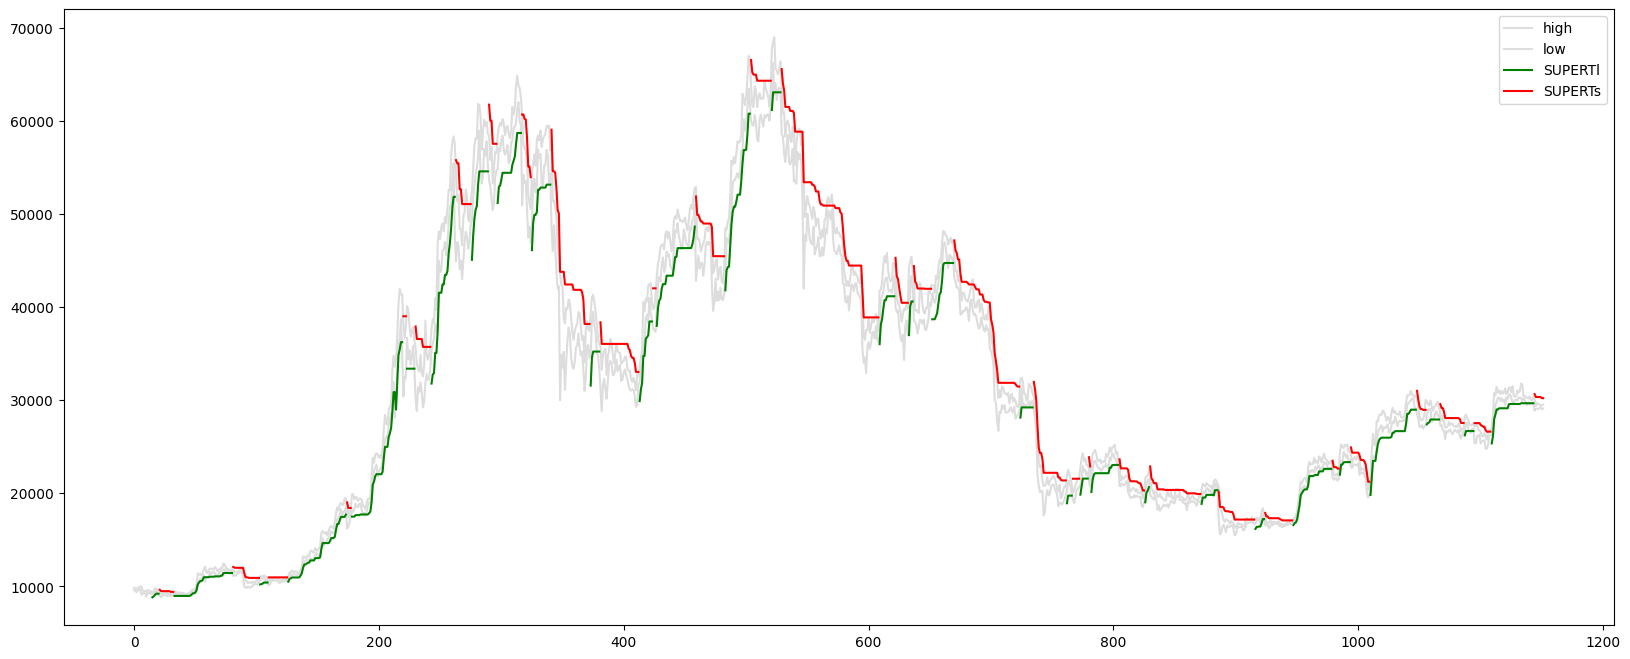

In [35]:
st_length = 15
st_multiplier = 1.5
df.ta.supertrend(length=st_length, multiplier=st_multiplier, append=True)

#Renombrando columnas del SuperTrend
cols = df.columns
posfix = ''
for col in cols:
    if col.startswith('SUPERT_'):
        posfix = col.replace('SUPERT','')
for col in cols:
    if col.endswith(posfix):
        new_col = col.replace(posfix,'')
        df.rename(columns={col: new_col}, inplace=True)

df['st_trigger'] = np.where((df['SUPERTd']>0) & (df['SUPERTd'].shift(1)<=0) ,1,0)
df['st_trigger'] = np.where((df['SUPERTd']<0) & (df['SUPERTd'].shift(1)>=0) ,-1,df['st_trigger'])
df[['high','low','SUPERTl','SUPERTs']].plot(figsize=(20,8),style=['#dddddd','#dddddd','g','r'])



#Tendencia basada en EMA_CROSS_HL2

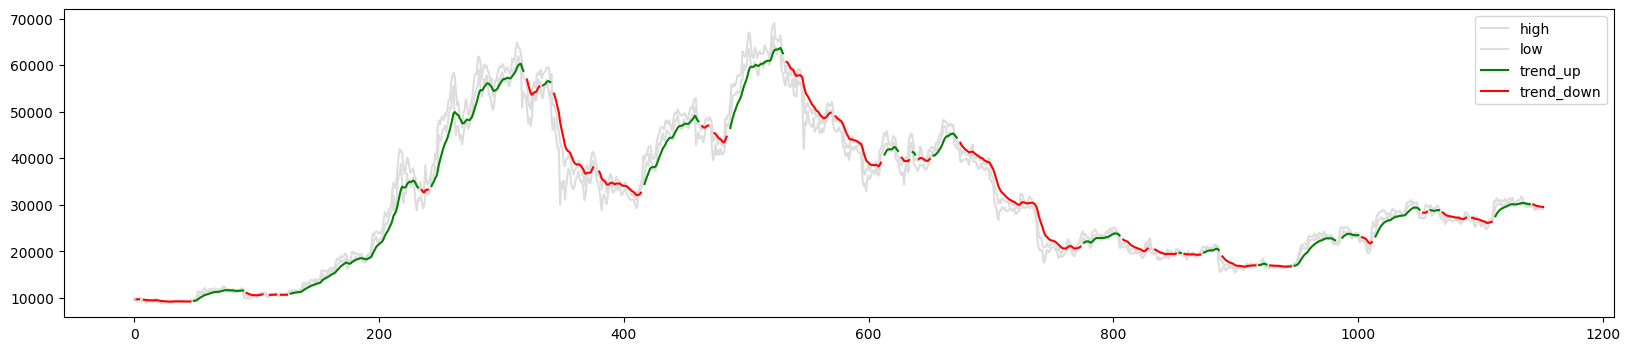

In [36]:

window = 3
ema_fast = 7
ema_slow = 21

df['hl2'] = (df['high'] + df['low']) / 2
df['ema_f'] = df['hl2'].ewm(span=ema_fast, adjust=False).mean()
df['ema_s'] = df['hl2'].ewm(span=ema_slow, adjust=False).mean()

df['cross'] = np.where(df['ema_f']>df['ema_s'],1,-1)

# Contar las veces consecutivas que 'cross' es igual a 1 en las últimas 5 filas
df['ema_signal'] = np.where(df['cross'].rolling(window=window).sum() == window, 1, 0 )

# Contar las veces consecutivas que 'cross' es igual a -1 en las últimas 5 filas
df['ema_signal'] = np.where(df['cross'].rolling(window=window).sum() == -window , -1, df['ema_signal'] )

df['trend_up'] = np.where(df['ema_signal']>0,(df['ema_f']+df['ema_s'])/2,None)
df['trend_down'] = np.where(df['ema_signal']<0,(df['ema_f']+df['ema_s'])/2,None)
df[['high','low','trend_up','trend_down']].plot(figsize=(20,4),style=['#dddddd','#dddddd','g','r'])
df = df.drop(['hl2','ema_f','ema_s','cross','ema_signal'], axis=1)



#Tendencia basada en EMA HIGH y LOW

<Axes: >

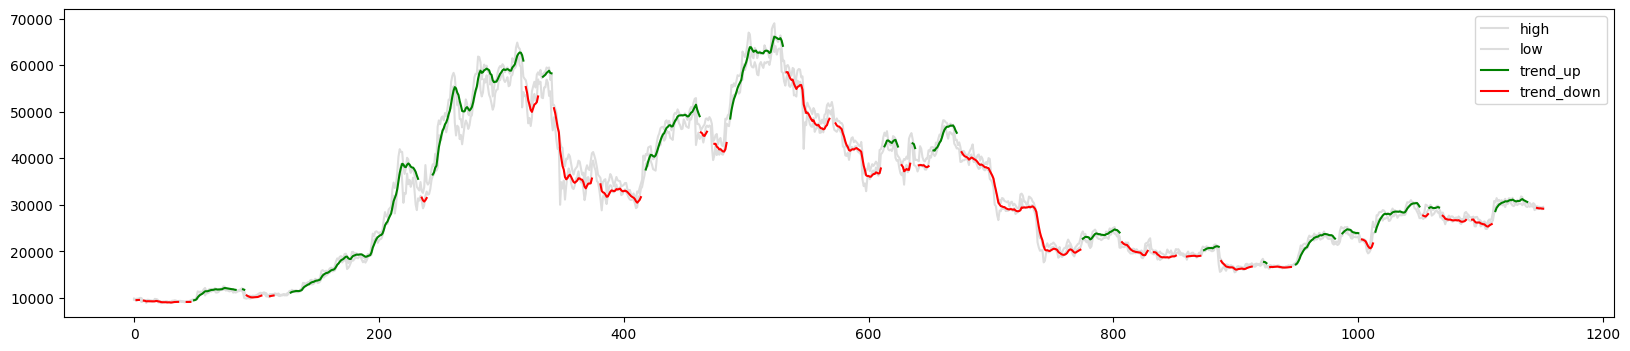

In [37]:
window = 3
ema_fast = 7
ema_low = 21

df['ema_h_f'] = df['high'].ewm(span=ema_fast, adjust=False).mean()
df['ema_h_s'] = df['high'].ewm(span=ema_low, adjust=False).mean()

df['ema_l_f'] = df['low'].ewm(span=ema_fast, adjust=False).mean()
df['ema_l_s'] = df['low'].ewm(span=ema_low, adjust=False).mean()

df['cross_h'] = np.where(df['ema_h_f']>df['ema_h_s'],1,-1)
df['cross_l'] = np.where(df['ema_l_f']>df['ema_l_s'],1,-1)


# Contar las veces consecutivas que 'cross' es igual a 1 en las últimas 5 filas
df['ema_signal'] = np.where(df['cross_h'].rolling(window=window).sum() == window, 1, 0 )

# Contar las veces consecutivas que 'cross' es igual a -1 en las últimas 5 filas
df['ema_signal'] = np.where(df['cross_l'].rolling(window=window).sum() == -window , -1, df['ema_signal'] )

df['trend_up'] = np.where(df['ema_signal']>0,df['ema_h_f'],None)
df['trend_down'] = np.where(df['ema_signal']<0,df['ema_l_f'],None)

df[['high','low','trend_up','trend_down']].plot(figsize=(20,4),style=['#dddddd','#dddddd','g','r'])